referensi: https://learnopencv.com/driver-drowsiness-detection-using-mediapipe-in-python/

In [1]:
!pip install mediapipe

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

In [3]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

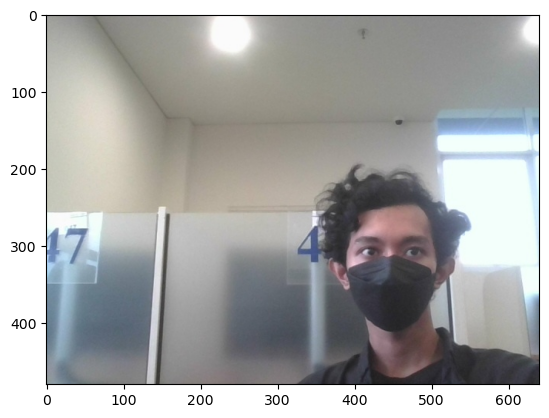

In [5]:
image = cv2.imread(r"C:/Users/ACER/OneDrive - Universitas Airlangga/KULIAH/semester 5/bbb data mining/final_project/final-project-datmin2/images/awake/awake.b082ba0a-6baf-11ed-aaf8-fc4482a2ef62.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
image = np.ascontiguousarray(image)
imgH, imgW, _ = image.shape

plt.imshow(image)

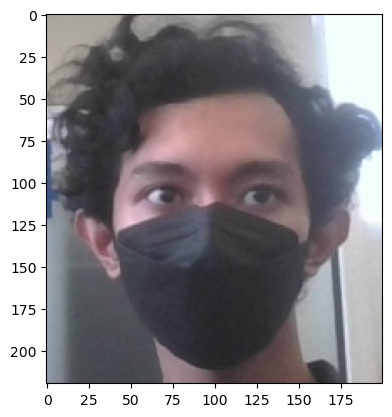

In [13]:
cropped_head = image[200:420, 350:550]
plt.imshow(cropped_head)

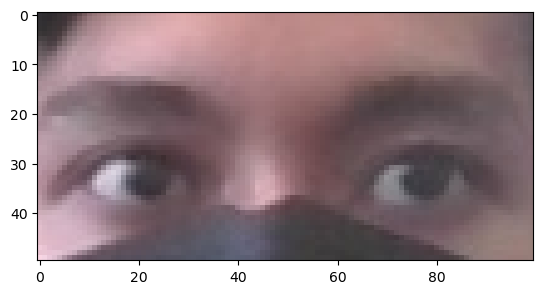

In [16]:
cropped_eye = cropped_head[75:125, 50:150]
plt.imshow(cropped_eye)

In [17]:
# Running inference using static_image_mode 
with mp_facemesh.FaceMesh(
    static_image_mode=True,         # Default=False
    max_num_faces=1,                # Default=1
    refine_landmarks=False,         # Default=False
    min_detection_confidence=0.5,   # Default=0.5
    min_tracking_confidence= 0.5   # Default=0.5
) as face_mesh:

    results = face_mesh.process(image)

# Indicates whether any detections are available or not.
print(bool(results.multi_face_landmarks))

True


In [18]:
landmark_0 = results.multi_face_landmarks[0].landmark[0]
print(landmark_0)

landmark_0_x = landmark_0.x * imgW 
landmark_0_y = landmark_0.y * imgH
landmark_0_z = landmark_0.z * imgW # according to documentation

print()
print("X:", landmark_0_x)
print("Y:", landmark_0_y)
print("Z:", landmark_0_z)

print()
print("Total Length of '.landmark':", len(results.multi_face_landmarks[0].landmark))

x: 0.6920629143714905
y: 0.7430754899978638
z: -0.02118150144815445


X: 442.9202651977539
Y: 356.6762351989746
Z: -13.556160926818848

Total Length of '.landmark': 468


In [19]:
def plot(
    *,
    img_dt,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 
    
    # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
    
    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
    
    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, 
        circle_radius=ts_circle_radius, 
        color=(255, 255, 255)
    )
    
    # Initialize a matplotlib figure.
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")
    
    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
    
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark
    
    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.
    
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                      )
            
        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                      )
            
    # Plot post-processed images
    plt.subplot(1, 3, 1)
    plt.title("Face Mesh Tessellation", fontsize=18)
    plt.imshow(image_drawing_tool)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("All eye landmarks", fontsize=18)
    plt.imshow(image_eye_lmks)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.axis("off")
    plt.show()
    plt.close()
    return

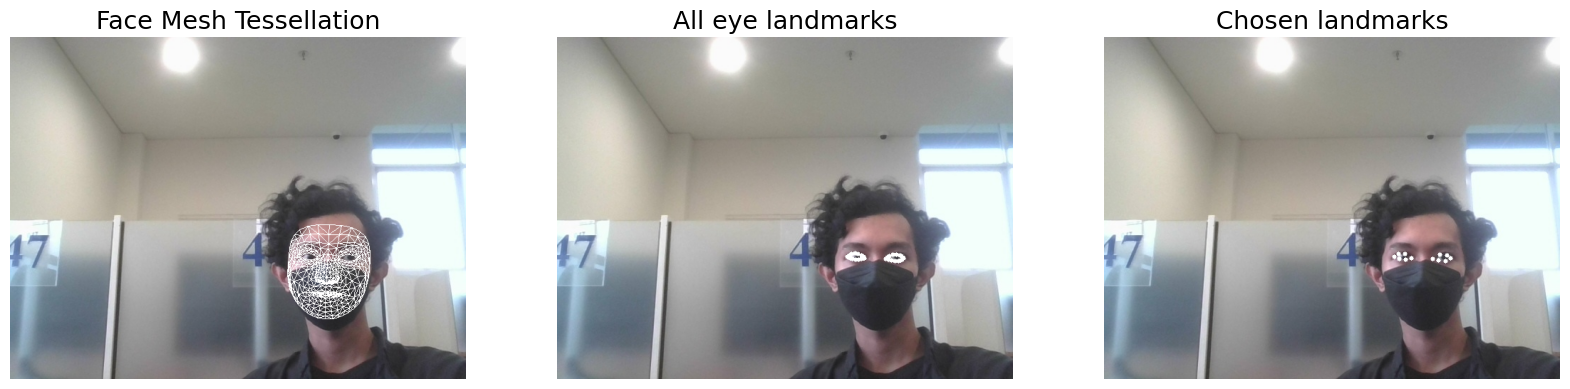

In [20]:
# If detections are available.
if results.multi_face_landmarks:
    # Iterate over detections of each face. Here, we have max_num_faces=1, 
    # So there will be at most 1 element in 
    # the 'results.multi_face_landmarks' list            
    # Only one iteration is performed.
    
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        _ = plot(img_dt=image.copy(), face_landmarks=face_landmarks)

In [21]:
def distance(point_1, point_2):
    """Calculate l2-norm between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [22]:
def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    """
    Calculate Eye Aspect Ratio for one eye.

    Args:
        landmarks: (list) Detected landmarks list
        refer_idxs: (list) Index positions of the chosen landmarks
                            in order P1, P2, P3, P4, P5, P6
        frame_width: (int) Width of captured frame
        frame_height: (int) Height of captured frame

    Returns:
        ear: (float) Eye aspect ratio
    """
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, 
                                             frame_width, frame_height)
            coords_points.append(coord)

        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])

        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)

    except:
        ear = 0.0
        coords_points = None

    return ear, coords_points

In [23]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    """Calculate Eye aspect ratio"""

    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    Avg_EAR = (left_ear + right_ear) / 2.0

    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

In [24]:
awake_full  = cv2.imread("capture/ur_capture/awake/awake.2f21cc55-6bb0-11ed-99b3-fc4482a2ef62.jpg")[:, :, ::-1]
awake_head = cv2.imread("capture/ur_capture/drowsy/drowsy.d48daa9d-6bb1-11ed-8b94-fc4482a2ef62.jpg")[:, :, ::-1]
awake_eye  = cv2.imread("capture/ur_capture/awake/awake.2f21cc55-6bb0-11ed-99b3-fc4482a2ef62.jpg")[:, :, ::-1]
# awake_full  = cv2.imread("capture/ur_capture/awake/awake.2f21cc55-6bb0-11ed-99b3-fc4482a2ef62.jpg")[:, :, ::-1]
# awake_head = cv2.imread("capture/ur_capture/drowsy/drowsy.d48daa9d-6bb1-11ed-8b94-fc4482a2ef62.jpg")[:, :, ::-1]
# awake_eye  = cv2.imread("capture/ur_capture/awake/awake.2f21cc55-6bb0-11ed-99b3-fc4482a2ef62.jpg")[:, :, ::-1]

for idx, image in enumerate([image_eyes_open, image_eyes_close]):

    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

    # Creating a copy of the original image for plotting the EAR value
    custom_chosen_lmk_image = image.copy()

    # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks

        # If detections are available.
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                      )

                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(custom_chosen_lmk_image, 
                            f"EAR: {round(EAR, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX, 
                            0.9, (255, 255, 255), 2
                )                

                plot(img_dt=image.copy(),
                     img_eye_lmks_chosen=custom_chosen_lmk_image,
                     face_landmarks=face_landmarks,
                     ts_thickness=1, 
                     ts_circle_radius=3, 
                     lmk_circle_radius=3
                )

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import cv2
import time
import numpy as np
import mediapipe as mp
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates as denormalize_coordinates

In [ ]:
def get_mediapipe_app(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
):
    """Initialize and return Mediapipe FaceMesh Solution Graph object"""
    face_mesh = mp.solutions.face_mesh.FaceMesh(
        max_num_faces=max_num_faces,
        refine_landmarks=refine_landmarks,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence,
    )

    return face_mesh

def plot_eye_landmarks(frame, left_lm_coordinates,
                       right_lm_coordinates, color
                      ):
    for lm_coordinates in [left_lm_coordinates, right_lm_coordinates]:
        if lm_coordinates:
            for coord in lm_coordinates:
                cv2.circle(frame, coord, 2, color, -1)

    frame = cv2.flip(frame, 1)
    return frame


def plot_text(image, text, origin, 
              color, font=cv2.FONT_HERSHEY_SIMPLEX, 
              fntScale=0.8, thickness=2
             ):
    image = cv2.putText(image, text, origin, font, fntScale, color, thickness)
    return image

In [ ]:
class VideoFrameHandler:
    def __init__(self):
        """
        Initialize the necessary constants, mediapipe app
        and tracker variables
        """
        # Left and right eye chosen landmarks.
        self.eye_idxs = {
            "left": [362, 385, 387, 263, 373, 380],
            "right": [33, 160, 158, 133, 153, 144],
        }

        # Used for coloring landmark points.
        # Its value depends on the current EAR value.
        self.RED = (0, 0, 255)  # BGR
        self.GREEN = (0, 255, 0)  # BGR

        # Initializing Mediapipe FaceMesh solution pipeline
        self.facemesh_model = get_mediapipe_app()

        # For tracking counters and sharing states in and out of callbacks.
        self.state_tracker = {
            "start_time": time.perf_counter(),
            "DROWSY_TIME": 0.0,  # Holds time passed with EAR < EAR_THRESH
            "COLOR": self.GREEN,
            "play_alarm": False,
        }

        self.EAR_txt_pos = (10, 30)

In [ ]:
def process(self, frame: np.array, thresholds: dict):
        """
        This function is used to implement our Drowsy detection algorithm.

        Args:
            frame: (np.array) Input frame matrix.
            thresholds: (dict) Contains the two threshold values
                               WAIT_TIME and EAR_THRESH.

        Returns:
            The processed frame and a boolean flag to
            indicate if the alarm should be played or not.
        """

        # To improve performance,
        # mark the frame as not writeable to pass by reference.
        frame.flags.writeable = False
        frame_h, frame_w, _ = frame.shape
        DROWSY_TIME_txt_pos = (10, int(frame_h // 2 * 1.7))
        ALM_txt_pos = (10, int(frame_h // 2 * 1.85))

        results = self.facemesh_model.process(frame)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            EAR, coordinates = calculate_avg_ear(landmarks,
                                                 self.eye_idxs["left"], 
                                                 self.eye_idxs["right"], 
                                                 frame_w, 
                                                 frame_h
                                                 )
            frame = plot_eye_landmarks(frame, 
                                       coordinates[0], 
                                       coordinates[1],
                                       self.state_tracker["COLOR"]
                                       )

            if EAR < thresholds["EAR_THRESH"]:

                # Increase DROWSY_TIME to track the time period with 
                # EAR less than the threshold
                # and reset the start_time for the next iteration.
                end_time = time.perf_counter()

                self.state_tracker["DROWSY_TIME"] += end_time - self.state_tracker["start_time"]
                self.state_tracker["start_time"] = end_time
                self.state_tracker["COLOR"] = self.RED

                if self.state_tracker["DROWSY_TIME"] >= thresholds["WAIT_TIME"]:
                    self.state_tracker["play_alarm"] = True
                    plot_text(frame, "WAKE UP! WAKE UP", 
                              ALM_txt_pos, self.state_tracker["COLOR"])

            else:
                self.state_tracker["start_time"] = time.perf_counter()
                self.state_tracker["DROWSY_TIME"] = 0.0
                self.state_tracker["COLOR"] = self.GREEN
                self.state_tracker["play_alarm"] = False

            EAR_txt = f"EAR: {round(EAR, 2)}"
            DROWSY_TIME_txt = f"DROWSY: {round(self.state_tracker['DROWSY_TIME'], 3)} Secs"
            plot_text(frame, EAR_txt, 
                      self.EAR_txt_pos, self.state_tracker["COLOR"])
            plot_text(frame, DROWSY_TIME_txt, 
                      DROWSY_TIME_txt_pos, self.state_tracker["COLOR"])

        else:
            self.state_tracker["start_time"] = time.perf_counter()
            self.state_tracker["DROWSY_TIME"] = 0.0
            self.state_tracker["COLOR"] = self.GREEN
            self.state_tracker["play_alarm"] = False

            # Flip the frame horizontally for a selfie-view display.
            frame = cv2.flip(frame, 1)

        return frame, self.state_tracker["play_alarm"]

In [ ]:
import os
import av
import threading
import streamlit as st
from streamlit_webrtc import VideoHTMLAttributes, webrtc_streamer

from audio_handling import AudioFrameHandler
from drowsy_detection import VideoFrameHandler

# Define the audio file to use.
alarm_file_path = os.path.join("audio", "wake_up.wav")

# Streamlit Components
st.set_page_config(
    page_title="Drowsiness Detection | LearnOpenCV",
    page_icon="https://learnopencv.com/wp-content/uploads/2017/12/favicon.png",
    layout="centered",
    initial_sidebar_state="expanded",
    menu_items={
        "About": "### Visit www.learnopencv.com for more exciting tutorials!!!",
    },
)

st.title("Drowsiness Detection!")

col1, col2 = st.columns(spec=[1, 1])

with col1:
    # Lowest valid value of Eye Aspect Ratio. Ideal values [0.15, 0.2].
    EAR_THRESH = st.slider("Eye Aspect Ratio threshold:", 0.0, 0.4, 0.18, 0.01)

with col2:
    # The amount of time (in seconds) to wait before sounding the alarm.
    WAIT_TIME = st.slider("Seconds to wait before sounding alarm:", 0.0, 5.0, 1.0, 0.25)

thresholds = {
    "EAR_THRESH": EAR_THRESH,
    "WAIT_TIME": WAIT_TIME,
}

# For streamlit-webrtc
video_handler = VideoFrameHandler()
audio_handler = AudioFrameHandler(sound_file_path=alarm_file_path)

# For thread-safe access & to prevent race-condition.
lock = threading.Lock()  

shared_state = {"play_alarm": False}

def video_frame_callback(frame: av.VideoFrame):
    frame = frame.to_ndarray(format="bgr24")  # Decode and convert frame to RGB

    frame, play_alarm = video_handler.process(frame, thresholds)  # Process frame
    with lock:
        shared_state["play_alarm"] = play_alarm  # Update shared state

    # Encode and return BGR frame
    return av.VideoFrame.from_ndarray(frame, format="bgr24")  

def audio_frame_callback(frame: av.AudioFrame):
    with lock:  # access the current “play_alarm” state
        play_alarm = shared_state["play_alarm"]

    new_frame: av.AudioFrame = audio_handler.process(frame,
                                                     play_sound=play_alarm)
    return new_frame

# ctx = webrtc_streamer(
#     key="driver-drowsiness-detection",
#     video_frame_callback=video_frame_callback,
#     audio_frame_callback=audio_frame_callback,
#     rtc_configuration={"iceServers": [{"urls": ["stun:stun.l.google.com:19302"]}]},
#     media_stream_constraints={"video": {"width": True, "audio": True},
#     video_html_attrs=VideoHTMLAttributes(autoPlay=True, controls=False, muted=False)
#                               )

# ctx = webrtc_steamer(
#     key="driver-drowsiness-detection",
#     video_frame_callback=video_frame_callback,
#     audio_frame_callback=audio_frame_callback,
#     rtc_configuration={"iceServers": [{"urls": ["stun:stun.l.google.com:19302"]}]},
#     media_stream_constraints={"video": {"width": True, "audio": True}},
#     video_html_attrs=VideoHTMLAttributes(autoPlay=True, controls=False, muted=False)
# )

In [ ]:
image_eyes_open  = cv2.imread("capture/ur_capture/awake/awake.2f21cc55-6bb0-11ed-99b3-fc4482a2ef62.jpg")[:, :, ::-1]
image_eyes_close = cv2.imread("capture/ur_capture/drowsy/drowsy.d48daa9d-6bb1-11ed-8b94-fc4482a2ef62.jpg")[:, :, ::-1]

for idx, image in enumerate([image_eyes_open, image_eyes_close]):

    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

    # Creating a copy of the original image for plotting the EAR value
    custom_chosen_lmk_image = image.copy()

    # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks

        # If detections are available.
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                      )

                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(custom_chosen_lmk_image, 
                            f"EAR: {round(EAR, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX, 
                            0.9, (255, 255, 255), 2
                )                

                plot(img_dt=image.copy(),
                     img_eye_lmks_chosen=custom_chosen_lmk_image,
                     face_landmarks=face_landmarks,
                     ts_thickness=1, 
                     ts_circle_radius=3, 
                     lmk_circle_radius=3
                )